In [1]:
import ROOT
from ROOT import TFile
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy
import pandas as pd 
import time
import root_pandas as rpd
from root_pandas import read_root


mpl.rcParams.update({'font.size': 18})
mpl.rcParams.update({'legend.fontsize': 20})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

Welcome to JupyROOT 6.22/06


In [188]:
def getRatio(df_A,df_D,df_trigger_A,df_trigger_D, variable='h2_z',trig_cut = 'h1_z>0.5', pair_cut='',minz=0.05,maxz=0.5,nbins=9, applyweight=False):
    #get number of pions with z>0.5
    print ('Print Trigger Cut ' ,trig_cut)
    print ('Total Cut ', trig_cut + pair_cut)
    
    norm_A = df_trigger_A.query(trig_cut).shape[0]
    norm_D = df_trigger_D.query(trig_cut).shape[0]
    
    #norm_A , xx = np.histogram( df_trigger_A.query(trig_cut),bins=np.array([0.5,1.0]))
    
    bins= np.linspace(minz,maxz,nbins)
    y_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=bins)
    y_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=bins)
    erry_A, x_conditional = np.histogram(df_A.query(trig_cut+pair_cut)[variable],bins=bins)
    erry_D, x_conditional = np.histogram(df_D.query(trig_cut+pair_cut)[variable],bins=bins)
  
    x_conditional = (x_conditional[1:] + x_conditional[:-1])/2.0
    err_A = np.true_divide(np.sqrt(erry_A),y_A)
    err_D = np.true_divide(np.sqrt(erry_D),y_D)
    y_A = np.true_divide(y_A,norm_A)
    y_D = np.true_divide(y_D,norm_D)
    ratio_conditional = np.true_divide(y_A,y_D)
    error_conditional = np.multiply(ratio_conditional, np.sqrt(np.power(err_A,2.0) + np.power(err_D,2.0)))
    
    return ratio_conditional,error_conditional,x_conditional

def applyCut(inputDataframe, cut, text=None):
    print('before the problem')
    nbeforecut = inputDataframe.shape[0]
    print('after the problem')
    cutDataframe = None
    if nbeforecut>0:
        cutDataframe = inputDataframe.query(cut)
        if text:
            print (text, cutDataframe.shape[0], ' (%2.2f '%(100.0*cutDataframe.shape[0]/nbeforecut), '%)')
    return cutDataframe

def applyCuts(fullDataframe,name='default',isMC=False,isTrigger=True): 
    dataframe = fullDataframe
    if(dataframe.shape[0]>0):
        print ('Entries before cut ', dataframe.shape[0])
    dataframe.eval('inelasticity = nu/5.014', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    #dataframe.eval('w2=(0.938272*0.938272+0.938272*nu-Q2)', inplace=True)
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    #dataframe = applyCut(dataframe, '(0.938272*0.938272+0.938272*nu-Q2)>4', 'W>2 ')
    dataframe = applyCut(dataframe, 'inelasticity<0.85','inelasticity < 0.85')
    dataframe = applyCut(dataframe, 'nu>3.0 and nu<3.5', '3.0 < Nu < 3.5')
    #dataframe = applyCut(dataframe, 'h_z>0.5', 'h_z>0.5 :')
    ##not sure why this cut
    #dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')
    dataframe = applyCut(dataframe, 'abs(h1_pid)==211', 'h1_pid = pions')
    return dataframe

def applyCutsPair(fullDataframe,name='default',isMC=False):
    print ('Starting election on dipion variables')
    if (isMC):
        print ('This is MC')
    else: 
        print ('This is Data')
    
    dataframe = fullDataframe
    dataframe.eval('z_tot = h1_z+ h2_z', inplace=True)
    dataframe.eval('h1_e = h1_z*nu', inplace=True)
    dataframe.eval('h2_e = h2_z*nu', inplace=True)
    dataframe.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    dataframe.eval('h2_p = sqrt(h2_e*h2_e-0.13957*0.13957)', inplace=True)
    dataframe.eval('pair_pt2 = pair_pt*pair_pt', inplace=True)
    #dataframe.eval('w2 = (0.938272*0.938272+0.938272*nu-Q2)', inplace=True)
    #dataframe = applyCut(dataframe, 'w2>4', 'W>2 ')
    dataframe = applyCut(dataframe, 'Q2>1.0', 'Q2>1.0 :')
    dataframe = applyCut(dataframe, 'nu>3.0 and nu<3.5', '3.0 < nu < 3.5')
    dataframe = applyCut(dataframe, 'pair_mass<1.5', 'pair_mass<1.5')
    dataframe = applyCut(dataframe, 'h1_z>0.5', 'h1_z>0.5 :')
    dataframe = applyCut(dataframe, 'h2_z>0.07', 'h2_z>0.07 :')
    #dataframe = applyCut(dataframe, 'h1_p <2.5 ', 'h1_p<2.5 ')
    #dataframe = applyCut(dataframe, 'h1_pid*h2_pid<0', 'Opposite sign pairs')
    #dataframe = applyCut(dataframe, 'h2_pid==2212 | abs(h2_pid)==211', 'h2_pid =2212 or pions') 
    dataframe = applyCut(dataframe, 'abs(h2_pid)==211', 'h2_pid = pions')
    dataframe = applyCut(dataframe, 'abs(h1_pid)==211', 'h1_pid = pions')

    ##Polar angle acceptance, different for 
    #if(isMC==False):
    #    print 'Polar angle acceptance'
    #    dataframe = applyCut(dataframe,'(pid_asso==211 & theta_lab_asso>10 & theta_lab_asso<90)|(pid_asso==-211 & theta_lab_asso>45 & theta_lab_asso<90)')
    if (not isMC):
        dataframe = applyCut(dataframe, 'h2_th<120 and h2_th>10', '10< h2_th<120')
        dataframe = applyCut(dataframe, 'h2_p>0.2', 'h2_p>0.2')
        #dataframe = applyCut(dataframe,'h2_pid==2212 | (h2_pid==211)| (h2_pid==-211 & h2_th>30)| (h2_pid==-211 & h2_th<30 & h2_p>0.600)','P>500 for pi- with theta<30')
        dataframe = applyCut(dataframe,'(h2_pid==211)| (h2_pid==-211 & h2_th>30)| (h2_pid==-211 & h2_th<30 & h2_p>0.6)','P>500 for pi- with theta<30')
        #dataframe = applyCut(dataframe,'(pid_asso==211 & theta_lab_asso>10.0)|(pid_asso==-211 & theta_lab_asso>30 & theta_lab_asso<120)')
    #dataframe = applyCut(dataframe, 'h2_p<2.5', 'h2_p <2.5 GeV')
    #dataframe = applyCut(dataframe, 'mass<2.0', 'mass < 2.0 GeV')
    
    return dataframe

def printPairBreakdown(dataframe):
    allpairs = 1.0*dataframe.shape[0]
    print ('All pairs ', allpairs)
    print ('Pairs with Leading pi+', np.true_divide(dataframe.query('h1_pid==211').shape[0],allpairs))
    print ('Pairs with Leading pi-', dataframe.query('h1_pid==-211').shape[0]/allpairs)
    print ('Pairs with Sub-Leading pi+', dataframe.query('h2_pid==211').shape[0]/allpairs)
    print ('Pairs with Sub-Leading pi-', dataframe.query('h2_pid==-211').shape[0]/allpairs)
    print ('pi+ pi+ pairs',dataframe.query('h1_pid==211 and h2_pid==211').shape[0]/allpairs)
    print ('pi- pi- pairs',dataframe.query('h1_pid==-211 and h2_pid==-211').shape[0]/allpairs)
    print ('pi+ pi- pairs',dataframe.query('h1_pid==211 and h2_pid==-211').shape[0]/allpairs)
    print ('pi- pi+ pairs',dataframe.query('h1_pid==-211 and h2_pid==211').shape[0]/allpairs)
    print ('//////////////////////////////////////////////////////')
    return

def getdatainChunks(filename,treename):
    dataframe =pd.DataFrame()
    for df in read_root(filename, treename, chunksize=100000) :
        #print df.shape[0]
        dataframe = pd.concat([dataframe,df])
    print (dataframe.shape[0])
    return dataframe



In [189]:
df = {}
df_trigger = {}
path="/home/miguel/eg2dihadron/"
for target in ['C','Fe','Pb']:
    print ('Getting dataframes from target %s'%target)
    df[target]=getdatainChunks('%sPairs_%s.root'%(path,target), target)
    df['D_%s'%target]= getdatainChunks('%sPairs_%s.root'%(path,target), 'D_%s'%target)  
    print ('Get trigger dataframes from deuterium target %s'%target)
    df_trigger['%s_trigger'%target] = getdatainChunks('%sPairs_%s.root'%(path,target), '%s_trigger'%target)
    df_trigger['D_%s_trigger'%target] = getdatainChunks('%sPairs_%s.root'%(path,target), 'D_%s_trigger'%target)



Getting dataframes from target C
235958
326770
Get trigger dataframes from deuterium target C
979565
1308621
Getting dataframes from target Fe
2200087
1815640
Get trigger dataframes from deuterium target Fe
3018956
3304308
Getting dataframes from target Pb
1852774
3514954
Get trigger dataframes from deuterium target Pb
2602253
6426401


In [190]:
#dataframees with pairs
print(df.keys())
for key in df.keys():
    isMC = False
    if 'GiBUU' in key:
        isMC=True
    print ('Inside dataframe with pairs, for key=',key)
    df[key] = applyCuts(df[key],isMC=isMC)
    df[key] = applyCutsPair(df[key],isMC=isMC)
    
for key in df_trigger.keys():
    print ('Inside dataframe with triggers, for key=',key)
    df_trigger[key] = applyCuts(df_trigger[key],isTrigger=True)
    print (' ')    

dict_keys(['C', 'D_C', 'Fe', 'D_Fe', 'Pb', 'D_Pb'])
Inside dataframe with pairs, for key= C
Entries before cut  235958
before the problem
after the problem
Q2>1.0 : 235958  (100.00  %)
before the problem
after the problem
inelasticity < 0.85 225920  (95.75  %)
before the problem
after the problem
3.0 < Nu < 3.5 76465  (33.85  %)
before the problem
after the problem
h1_pid = pions 76465  (100.00  %)
Starting election on dipion variables
This is Data
before the problem
after the problem
Q2>1.0 : 76465  (100.00  %)
before the problem
after the problem
3.0 < nu < 3.5 76465  (100.00  %)
before the problem
after the problem
pair_mass<1.5 75822  (99.16  %)
before the problem
after the problem
h1_z>0.5 : 35378  (46.66  %)
before the problem
after the problem
h2_z>0.07 : 34249  (96.81  %)
before the problem
after the problem
h2_pid = pions 34249  (100.00  %)
before the problem
after the problem
h1_pid = pions 34249  (100.00  %)
before the problem
after the problem
10< h2_th<120 33764  (98.58  %

before the problem
after the problem
Q2>1.0 : 2602253  (100.00  %)
before the problem
after the problem
inelasticity < 0.85 2534788  (97.41  %)
before the problem
after the problem
3.0 < Nu < 3.5 836468  (33.00  %)
before the problem
after the problem
h1_pid = pions 150006  (17.93  %)
 
Inside dataframe with triggers, for key= D_Pb_trigger
Entries before cut  6426401
before the problem
after the problem
Q2>1.0 : 6426401  (100.00  %)
before the problem
after the problem
inelasticity < 0.85 6234053  (97.01  %)
before the problem
after the problem
3.0 < Nu < 3.5 2184845  (35.05  %)
before the problem
after the problem
h1_pid = pions 674529  (30.87  %)
 


In [ ]:
#df_mc = {}
#df_mc_trigger = {}

#for target in ['D','C']:
#    print ('Getting dataframes from target %s'%target)
#    df_mc[target]=getdatainChunks('%sMC_Pairs_%s.root'%(path,target), target)
#    df_mc_trigger['%s_trigger'%target] = getdatainChunks('%sMC_Pairs_%s.root'%(path,target), '%s_trigger'%target)

In [ ]:
#for target in ['D','C','Fe','Pb']:
    #GiBUU
#    print (target)
#    print (' trigger')
#    df_trigger['GiBUU_%s_trigger'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(path,target), '%s_trigger'%target)
#    print (' pairs')
#    df['GiBUU_%s'%target]= getdatainChunks('%sGiBUU_Pairs_%s.root'%(path,target), target)
#print (df.keys())



In [31]:
#for key in df_mc.keys():
#    isMC = False
#    if 'GiBUU' in key:
#        isMC=True
    
#    print (key)
    
#    df_mc[key] = applyCuts(df_mc[key],isMC=isMC)
#    df_mc[key] = applyCutsPair(df_mc[key],isMC=isMC)    
    
#    df_mc[key] = applyCuts(df_mc[key],isMC=isMC)
#    df_mc[key] = applyCutsPair(df_mc[key],isMC=isMC)

In [ ]:
#for key in df_mc_trigger.keys():
#    print (key)
#    df_mc_trigger[key] = applyCuts(df_mc_trigger[key],isTrigger=True)
#    print (' ')

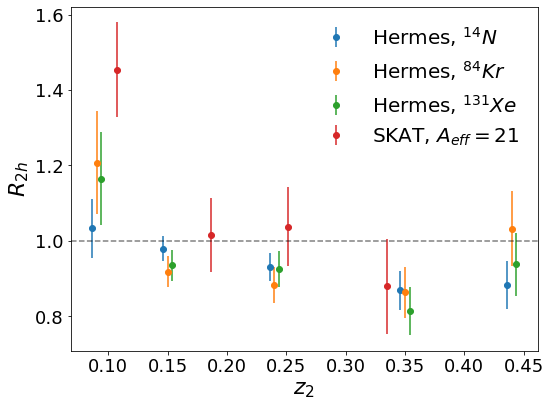

In [6]:
#hermes data:
hermes_y = {}
hermes_ystat = {}
hermes_ysyst = {}
hermes_ytotal = {}

#DATA FROM SELECTIO1 OF http://www-hermes.desy.de/notes/pub/publications.html
hermes_x = {}
hermes_x['Kr'] = [0.09,0.15,0.24,0.35,0.44]
hermes_x['N'] = np.subtract(hermes_x['Kr'],0.004)
hermes_x['Xe'] = np.subtract(hermes_x['Kr'],-0.004)

#nitrogen, atomic number 7
hermes_y['N']     = [1.0324, 0.9781,0.9293,0.8678,0.8822]
hermes_ystat['N'] = [0.0767,0.0268,0.0323,0.0478,0.0601]
hermes_ysyst['N'] = [0.0206,0.0196,0.0186,0.0174,0.0176]
hermes_ytotal['N'] = np.sqrt(np.power(hermes_ystat['N'],2.0)+np.power(hermes_ysyst['N'],2.0))

#krypton, atomic number 36
hermes_y['Kr'] = [1.2072,0.9180,0.8822,0.8631,1.0314]
hermes_ystat['Kr'] = [0.1342,0.0366,0.0452,0.0661,0.0972]
hermes_ysyst['Kr'] =[0.0241,0.0184,0.0176,0.0173,0.0206]
hermes_ytotal['Kr'] = np.sqrt(np.power(hermes_ystat['Kr'],2.0)+np.power(hermes_ysyst['Kr'],2.0))

hermes_y['Xe'] = [1.1648,0.9345,0.9242,0.8128,0.9373]
hermes_ystat['Xe'] = [0.1205,0.0359,0.0433,0.0614,0.0808]
hermes_ysyst['Xe'] = [0.0233,0.0187,0.0185,0.0163,0.0187]
hermes_ytotal['Xe'] = np.sqrt(np.power(hermes_ystat['Xe'],2.0)+np.power(hermes_ysyst['Xe'],2.0))


neutrino_x = [0.10763636363636367, 0.18618181818181817,0.25163636363636366,0.3345454545454546]
neutrino_y = [1.4535664335664338, 1.0148378893833438,  1.0373426573426574, 0.8784361093452003]
neutrino_yerror =[1.5794405594405596, 1.112739987285442, 1.1422377622377624,1.004310235219326]
neutrino_yerror = np.subtract(neutrino_yerror,neutrino_y)

fig = plt.figure(figsize=(8,6))

plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],label='Hermes, $^{14}N$',fmt='o')
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],label='Hermes, $^{84}Kr$',fmt='o')
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],label='Hermes, $^{131}Xe$',fmt='o')
plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,label='SKAT, $A_{eff}=21$',fmt='o')
plt.xlabel('$z_{2}$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--',alpha=0.5)

plt.tight_layout()
plt.legend(frameon=False)
#plt.savefig('PreviousData.png')
#plt.savefig('PreviousData_R2h.pdf')

#plt.show()

Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5
Print Trigger Cut  h1_z>0.5
Total Cut  h1_z>0.5


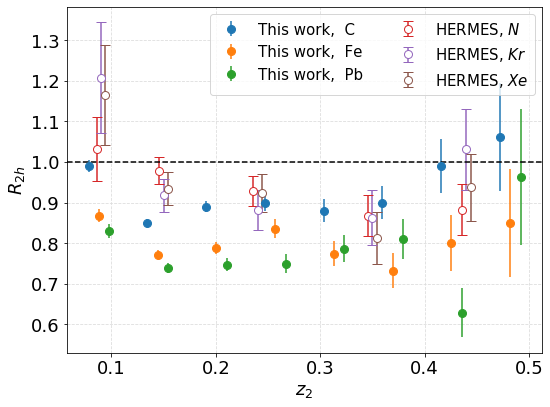

In [191]:
fig = plt.figure(figsize=(8,6))
for i,target in enumerate(['C','Fe','Pb']):
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], 
                        df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target],
                        minz=0.05)
    plt.errorbar(x+0.01*i,r,yerr=err,label='This work,  %s'%target,fmt='o',ms=8)

plt.xlabel('$z_{2}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)
plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',mfc='white',label='HERMES, $N$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',mfc='white',label='HERMES, $Kr$',fillstyle=None,ms=8,capsize=5)
plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',mfc='white',label='HERMES, $Xe$',fillstyle=None,ms=8,capsize=5)
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

#plt.ylim([0.5,1.3])
#plt.xlim([0.00,0.5])
plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=True,fontsize=15,ncol=2)
plt.grid(True, axis='x',color='gainsboro', linestyle='dashed')
plt.grid(True, axis='y',color='gainsboro', linestyle='dashed')
plt.tight_layout()
#plt.savefig('ComparisonWithHermes_Linear.png')
#plt.xlim([0.05,0.5])

#plt.xscale('log')
#plt.savefig('ComparisonWithHermes_Log.png')

plt.show()



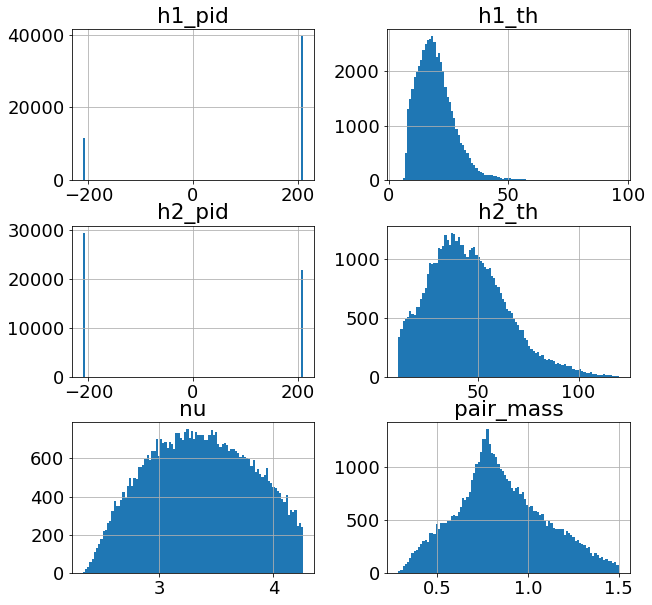

In [151]:
df['Fe'].hist(figsize=(10,10),bins=100,column=['h1_pid','h1_th','h2_th','h2_pid','pair_mass', 'nu'])
plt.show()

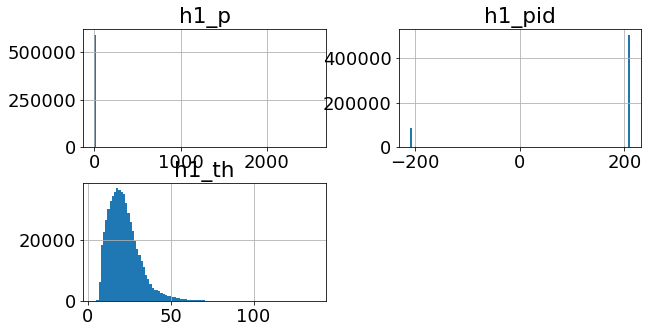

In [148]:
df_trigger['Fe_trigger'].hist(figsize=(10,5),bins=100,column=['h1_pid','h1_th', 'h1_p'])
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))

for i,target in enumerate(['C']):
    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08)
    
    plt.errorbar(x+0.01,r,yerr=err,label='all pairs,  %s'%target,fmt='o',ms=8)
    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08,    pair_cut='and h1_pid>0 and h2_pid<0')
    plt.errorbar(x+0.02,r,yerr=err,label='$\pi^{+}$, $\pi^{-}$',fmt='o',ms=8)
    
    
    r, err,x = getRatio(df_mc['%s'%target], df_mc['D'], 
                        df_mc_trigger['%s_trigger'%target], df_mc_trigger['D_trigger'],
                        minz=0.08,    pair_cut='and h1_pid<0 and h2_pid>0')
    plt.errorbar(x+0.03,r,yerr=err,label='$\pi^{-}$, $\pi^{+}$',fmt='o',ms=8)
    
plt.ylabel(r'$R_{2h}$',fontsize=22)
plt.xlabel(r'$z_{2}$',fontsize=22)
plt.ylim([0.5,1.5])
plt.legend(frameon=False,loc='best')

In [ ]:
df['GiBUU_C'].keys()

fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and h2_pid==2212',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
for target in ['Fe']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut='and h2_pid==2212',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
plt.xlabel('Pair $p_{T}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.xscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')


In [ ]:


fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and abs(h2_pid)==2212',minz=-1.5,maxz=3.0,nbins=20,variable='h2_rap')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)

    
for target in ['Fe']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                       pair_cut='and abs(h2_pid)==2212',minz=-1.5,maxz=3.0,nbins=20,variable='h2_rap')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
plt.xlabel('proton rapidity',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.yscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')



In [ ]:
fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0',minz=0.0,maxz=3.14,nbins=20,variable='dphi')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
for target in ['Fe']:
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut='and abs(h2_pid)==2212 and h2_z>0.1 and h2_rap>-1.5 and h2_rap<-1.0',minz=0.0,maxz=3.14,nbins=20,variable='dphi')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
plt.xlabel('$\Delta\phi$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.yscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')

In [ ]:


fig = plt.figure(figsize=(8,6))

for target in ['C','Fe','Pb']:
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],
                        df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                        pair_cut='and h2_pid==2212',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
    plt.errorbar(x,r,yerr=err,label='GiBUU %s'%target,ms=8,lw=2)
for target in ['Fe']:
    
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target],
                        df_trigger['D_%s_trigger'%target],
                        pair_cut='and h2_pid==2212',minz=0.01,maxz=1.0,nbins=20,variable='pair_pt')
                       
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)

plt.xlabel('Pair $p_{T}$',fontsize=18)
plt.ylabel('$R_{2h}$',fontsize=18)

#plt.xlim([0.06,0.5])
#plt.ylim([0.0,2.0])

plt.axhline(y=1.0,color='black',linestyle='--')
plt.legend(loc='best',frameon=False,fontsize=15,ncol=1)


#plt.xscale('log')

plt.tight_layout()
plt.savefig('TheoryOnly.png')



In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from matplotlib.offsetbox import AnchoredText

from mpl_toolkits.mplot3d.axes3d import get_test_data

def dphi_deta_plot(df,df_trig,deta_range=(-2,6),bins=20,fig=None):
    dphi_range = (-np.pi/2,3*np.pi/2)
    x = df.drap
    y = df.dphi
    if fig == None:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111, projection='3d')
    hist, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[deta_range, dphi_range])
    
    denom = len(df_trig)*2*np.pi/bins*(deta_range[1]-deta_range[0])/bins
    hist = np.divide(hist, denom)
    xpos, ypos = np.meshgrid(np.add(xedges[:-1],xedges[1:])/2, np.add(yedges[:-1],yedges[1:])/2)
    zpos = 0

    surf = ax.plot_surface(xpos, ypos, hist.transpose(), cmap=cm.coolwarm,edgecolor='k')
    ax.set_xlabel("$\\Delta y$")
    ax.set_ylabel("$\\Delta\\phi$")
    ax.set_zlabel("$\\frac{1}{N_{\\mathrm{trig}}}\\frac{dN}{d\\Delta\\phi d\\Delta y}$",rotation=-90)
    ax.set_xlim(*deta_range)
    ax.set_ylim(*dphi_range)
    return fig,ax
df_temp = df['Fe'].query("h1_z>0.5"\
                         + "and abs(h2_pid) == 211")
df_trig_temp = df_trigger['Fe_trigger'].query("h1_z>0.5")
fig,ax = dphi_deta_plot(df_temp,df_trig_temp,
              deta_range=(0,5))
plt.gca().add_artist(AnchoredText("$\pi^+p$\n$p_T>0.3$ GeV\n$Q^2>1$ GeV$^2$\n$W>2$ GeV\n$z_\\pi>0.5$",loc='upper left'))
#plt.savefig("../images/dphi_vs_deta_pip_p.pdf",bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))



for i,target in enumerate(['C','Fe','Pb']):
    #data
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.05,maxz=0.5
                       )
    plt.errorbar(np.subtract(x,-i*0.005),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.99,color=colors[target])
    plt.fill_between(np.subtract(x,-i*0.005), r*0.94,r*1.04, color=colors[target],alpha=0.2)
    
    
    #gibuu
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='h2_z',minz=0.05,maxz=0.5, applyweight=False, pair_cut = ' and abs(h2_pid)==211'
                       )
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])

#plt.xscale('log')
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.ylim([0.0,1.5])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


#plt.errorbar(hermes_x['N'], hermes_y['N'],yerr=hermes_ytotal['N'],fmt='o',label='Hermes, N',fillstyle=None,ms=8,capsize=5,color='grey')
#plt.errorbar(hermes_x['Kr'], hermes_y['Kr'],yerr=hermes_ytotal['Kr'],fmt='o',label='Hermes, Kr',fillstyle=None,ms=8,capsize=5,color='brown')
#plt.errorbar(hermes_x['Xe'], hermes_y['Xe'],yerr=hermes_ytotal['Xe'],fmt='o',label='Hermes, Xe',fillstyle=None,ms=8,capsize=5,color='darkviolet')
#plt.errorbar(neutrino_x, neutrino_y,yerr=neutrino_yerror,fmt='s',mfc='white',label='Neutrino, $A_{eff}=21$',fillstyle=None,ms=8,capsize=5)

plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
#plt.text(0.20, 1.2, 'CLAS \nINTERNAL', fontsize=30)

plt.legend(frameon=False,ncol=2,fontsize=15)
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2_withHERMES.png')
plt.savefig('MainResult_withGiBUU_z2_withHERMES.pdf')

In [ ]:
fig = plt.figure(figsize=(8,6))

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

for i,target in enumerate(['Fe']):
    #data
    
  
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.07,maxz=0.5,applyweight=False
                       )
    plt.errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])

   
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.ylim([0.0,1.5])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')


plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)

plt.legend(frameon=False,ncol=3,fontsize=15)
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2_withHERMES.png')
plt.savefig('MainResult_withGiBUU_z2_withHERMES.pdf')

In [ ]:
x_data = np.array([0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95])
y_data = {}
erry_data  ={}

y_data['pip_C'] = np.array([1.16751 , 1.01848 , 0.926135 , 0.876012 , 0.8595 , 0.848906 , 0.832911 , 0.762776 , 0.782656 , 0.698996 ])
erry_data['pip_C'] = np.array([0.00321583 , 0.00161351 , 0.00188183 , 0.00233672 , 0.00297862 , 0.00369811 , 0.00445801 , 0.00520291 , 0.00703654 , 0.00844543])
y_data['pip_Fe'] = np.array([1.18002 , 0.931569 , 0.772485 , 0.695442 , 0.653029 , 0.636352 , 0.609999 , 0.549825 , 0.538038 , 0.440439])
erry_data['pip_Fe'] = np.array([0.00297786 , 0.00136259 , 0.00146705 , 0.00175402 , 0.00214668 , 0.00261719 , 0.00307546 , 0.00352656 , 0.00457231 , 0.00516023])
y_data['pip_Pb'] = np.array([0.980339 , 0.747191 , 0.597805 , 0.522714 , 0.4807 , 0.466481 , 0.446264 , 0.399832 , 0.386629 , 0.277573 ])
erry_data['pip_Pb'] = np.array([0.0028235 , 0.00128281 , 0.00136618 , 0.00163387 , 0.00199655 , 0.0024583 , 0.00293294 , 0.00343855 , 0.00452875 , 0.0049117])



fig = plt.figure(figsize=(8,6))

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

for i,target in enumerate(['Fe']):
    #data
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.07,maxz=0.5,applyweight=False
                       )
    plt.errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='This work, %s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])
    plt.errorbar(x_data,y_data['pip_%s'%target],yerr=erry_data['pip_%s'%target],color=colors[target],fmt='s-',label=target)

    #gibuu
    #r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
    #                   ,variable='z_asso',minz=0.07,maxz=0.5#,pair_cut='and z_asso>0.1'
    #                   )
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.9,lw=5)
    #plt.plot(x,r,label='GiBUU %s'%target,alpha=0.79,lw=3,color=colors[target])

    plt
#plt.xscale('log')
plt.xlabel('$z_2$',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')
#plt.ylim([0.0,1.5])
plt.xlim([0.0,0.5])

plt.tight_layout()
plt.savefig('MainResult_withGiBUU_z2.png')

In [ ]:
fig = plt.figure(figsize=(16,12))


label = {} 
label['C'] = '$^{12}C$'
label['Fe'] = '$^{56}Fe$'
label['Pb'] = '$^{208}Pb$'


colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

colors['C_pip'] = '#ff7f0e'
colors['Fe_pip'] = '#d62728'
colors['Pb_pip']=  '#8c564b'


fig, axs = plt.subplots(1, 3,sharex=True, sharey=True,figsize=(16,6),gridspec_kw={'hspace': 0, 'wspace':0})

for i,target in enumerate(['Fe']):

    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='h2_z',minz=0.05,maxz=0.5,applyweight=False
                       )
    axs[i].errorbar(np.subtract(x,0*0.0025),r,yerr=err,label='conditional',ms=8,fmt='o',alpha=0.8,color=colors[target])
    axs[i].fill_between(x, 1.04*r,0.96*r,alpha=0.2,color=colors[target])
   


    axs[i].set_xlim([0.0,0.5])

    axs[i].errorbar(x_data,y_data['pip_%s'%target],yerr=erry_data['pip_%s'%target],color='black',fmt='s',ms=8,alpha=0.7,label='inclusive')
    axs[i].fill_between(x_data, 1.03*y_data['pip_%s'%target],0.97*y_data['pip_%s'%target],color='black',alpha=0.2)

    
    axs[i].legend(loc='lower left',ncol=1,frameon=False,fontsize=19)
    axs[i].xaxis.set_label_text('$z$',fontsize=22)

axs[0].set_title('$^{}C$',fontsize=22)
axs[1].set_title('$^{}Fe$',fontsize=22)
axs[2].set_title('$^{}Pb$',fontsize=22)
axs[0].yaxis.set_label_text('Suppression factor',fontsize=22)

In [ ]:
fig = plt.figure(figsize=(8,6))

colors = {}
colors['C'] = '#1f77b4'
colors['Fe'] = '#ff7f0e'
colors['Pb']=  '#2ca02c'

for i,target in enumerate(['Fe']):
    r, err,x = getRatio(df['%s'%target], df['D_%s'%target], df_trigger['%s_trigger'%target], df_trigger['D_%s_trigger'%target]
                       ,variable='pair_mass',minz=0.4,maxz=2.0,nbins=11,pair_cut='and h2_z>0.10',applyweight=False
                       )
    plt.errorbar(x+0.02*i,r,yerr=err,label='%s'%target,ms=8,fmt='o',alpha=0.8,color=colors[target])
    plt.fill_between(x+0.02*i,r*1.04,r*0.96, alpha=0.2,color=colors[target])
    
    
    r, err,x = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger']
                       ,variable='pair_mass',minz=0.4,maxz=2.0,nbins=11,pair_cut='and h2_z>0.10',applyweight=False
                       )
    #plt.fill_between(x,r,r-err,r+err,label='GiBUU %s'%target,alpha=0.5)
    plt.plot(x+0.02*i,r,color=colors[target],lw=3,alpha=0.8,label='GiBUU %s'%target)
plt.tick_params(axis="x", labelsize=16)
plt.tick_params(axis="y", labelsize=16)
plt.legend(frameon=False,ncol=2,loc='upper left')
plt.xlabel('Dipion mass (GeV)',fontsize=22)
plt.ylabel('$R_{2h}$',fontsize=22)
plt.axhline(y=1.0,color='black',linestyle='--')

#plt.text(0.60, 1.1, 'CLAS \nINTERNAL', fontsize=30)

#plt.ylim([0.0,1.2])
plt.tight_layout()
plt.savefig('MainResult_withGiBUU_mass.png')
plt.savefig('MainResult_withGiBUU_mass.pdf')

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['Fe']:
    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='h2_z')
    axs[0].errorbar(x,r,yerr=err,label=target,fmt='o',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                          df_trigger['GiBUU_D_trigger'],applyweight=False
                          )
    axs[0].fill_between(x,r+err,r-err,label='GiBUU %s'%target,alpha=0.5)

    r, err, x = getRatio(df[target],df['D_%s'%target],df_trigger['%s_trigger'%target],df_trigger['D_%s_trigger'%target],nbins=24,variable='h2_z',pair_cut=' and z_tot<0.8')
    axs[1].errorbar(x,r,yerr=err,label=target,fmt='o',mfc='white',ms=8,lw=3,capsize=5)
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],df_trigger['GiBUU_D_trigger'],
                         pair_cut=' and z_tot<0.80',applyweight=False)
    axs[1].fill_between(x,r+err,r-err,label='GiBUU %s'%target,alpha=0.5)
    
    
axs[1].axhline(y=1.0,color='black',linestyle='--')
axs[0].axhline(y=1.0,color='black',linestyle='--')

axs[1].set_title('with $z_1+z_2<$0.8', fontsize=13)
axs[0].set_title('no cut ', fontsize=13)

axs[0].legend()
axs[1].legend()

plt.tight_layout()
plt.savefig('ExclusiveCutVariation.png')
plt.show()

In [ ]:
for target in ['Fe']:
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})
  
    ##Negative associated hadron
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='h1_pid>0', pair_cut='and h2_pid<0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, +/-'%target,fmt='o',ms=8,lw=3,capsize=5)
    
    r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target], trig_cut = 'h1_pid<0',pair_cut='and h2_pid>0',maxz=0.4)
    axs[0].errorbar(x,r,yerr=err,label='%s, -/+'%target,fmt='o',ms=8,lw=3,capsize=5)



    ##GiBUU negative trigger
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                          df_trigger['GiBUU_D_trigger'],trig_cut='h1_pid>0',  pair_cut='and h2_pid<0',applyweight=False)                                              
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi- asso'%target,ms=8,lw=3,capsize=5)

    
    
    ##GiBUU positive trigger
    r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
                          df_trigger['GiBUU_D_trigger'],trig_cut='h1_pid<0', pair_cut='and h2_pid>0',applyweight=False)                                              
    axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, pi+ asso'%target,ms=8,lw=3,capsize=5)
    
    ##GiBUU all hadrons
    #r, err, x  = getRatio(df['GiBUU_%s'%target],df['GiBUU_D'],df_trigger['GiBUU_%s_trigger'%target],
    #                      df_trigger['GiBUU_D_trigger'])                                              
    #axs[1].errorbar(x,r,yerr=err,label='GiBUU %s, all'%target,ms=8,lw=3,capsize=5)
    


    axs[1].axhline(y=1.0,color='black',linestyle='--')
    axs[0].axhline(y=1.0,color='black',linestyle='--')

    axs[0].legend(frameon=False)
    axs[1].legend(frameon=False)


    plt.savefig('ConsistencyCharge_%s.png'%target)
    plt.show()
    plt.clf()

In [ ]:
plt.hist(df['Fe'].query('h1_pid>0')['h2_th'],bins=100,alpha=0.5,label='positive trigger')
plt.hist(df['Fe'].query('h1_pid<0')['h2_th'],bins=100,alpha=0.5,label='negative trigger')
plt.legend()
plt.xlabel('theta lab asso')
plt.show()

In [ ]:


fig, axs = plt.subplots(1, 2, sharey=True, figsize=(12,6), gridspec_kw={'hspace': 0, 'wspace':0})


Edges = [25,40,55,80]
bins = [(x, y) for (x, y) in zip(Edges[:-1], Edges[1:])]
for target in ['Fe']:
    for j, ibin in enumerate(bins):

        pair_cut = 'and h2_th>%2.2f and h2_th<=%2.2f'%(ibin[0],ibin[1])
        label = '%2.0f$<\Theta<$%2.0f, D'%(ibin[0],ibin[1])

    
    ##Positive trigger
        r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='h1_pid>0', 
                          pair_cut=pair_cut,minz=0.07,nbins=8)
        axs[0].errorbar(x,r,yerr=err,fmt='o',ms=8,lw=3,capsize=5,label=label)
        
        ##negative trigger
        
        r, err, x  = getRatio(df['%s'%target],df['D_%s'%target],df_trigger['%s_trigger'%target],
                          df_trigger['D_%s_trigger'%target],trig_cut='h1_pid<0', 
                          pair_cut=pair_cut,minz=0.07,nbins=8)
        axs[1].errorbar(x,r,yerr=err,fmt='o',ms=8,lw=3,capsize=5,label=label)
        
axs[0].legend(frameon=False,fontsize=12,ncol=2)
axs[1].legend(frameon=False,fontsize=12,ncol=1)



In [ ]:


fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['Fe']):
    plt.subplot(2,2,i+1)
    plt.hist(df[target].query('h1_z>0.5 and h2_pid>0')['h2_z'], bins=100,range =(0,0.5),label='$\pi^+$',alpha=0.5)
    plt.hist(df[target].query('h1_z>0.5 and h2_pid<0')['h2_z'], bins=100,range =(0,0.5),label='$\pi^-$',alpha=0.5)

    plt.title('%s, Conditional for $z_{1}>0.5$'%target)
    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{2}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('ConditionalDistribution_z2_BothPions.png')



In [ ]:


fig = plt.figure( figsize=(12, 10))

for i, target in enumerate(['Fe']):
    plt.subplot(2,2,i+1)
    plt.hist(df_trigger['%s_trigger'%target].query('h1_z>0.5 and h1_pid>0')['h1_z'], bins=100,range =(0.5,1.0),label='$\pi^+$',alpha=0.5)
    plt.hist(df_trigger['%s_trigger'%target].query('h1_z>0.5 and h1_pid<0')['h1_z'], bins=100,range =(0.5,1.0),label='$\pi^-$',alpha=0.5)

    plt.ylabel('pairs',fontsize=16)
    plt.xlabel('$z_{1}$',fontsize=16)
    plt.legend(frameon=False)    

plt.savefig('Triggers.png')



In [ ]:


fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['Fe']:
    axs[0].hist(df['GiBUU_%s'%target]['h2_p'],bins=50,density=True,range=(0.0,2.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['h2_p'],bins=50,density=True,range=(0.0,2.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$P_{2}$ (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('$P_{2}$ (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()



In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['Fe']:
    axs[0].hist(df_trigger['GiBUU_%s_trigger'%target]['nu'],bins=50,density=True,range=(2.0,5.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df_trigger['%s_trigger'%target]['nu'],bins=50,density=True,range=(2.0,5.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Nu (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('Nu (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
#axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
#axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['Fe']:
    axs[0].hist(df_trigger['GiBUU_%s_trigger'%target]['Q2'],bins=50,density=True,range=(1.0,4.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df_trigger['%s_trigger'%target]['Q2'],bins=50,density=True,range=(1.0,4.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Q2 (GeV2)',fontsize=18)
axs[1].xaxis.set_label_text('Q2 (GeV2)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
#axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
#axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['z_tot'],bins=50,density=True,range=(0.5,1.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['z_tot'],bins=50,density=True,range=(0.5,1.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('$z_{tot}$',fontsize=18)
axs[1].xaxis.set_label_text('$z_{tot}$',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()


In [ ]:
fig, axs = plt.subplots(1, 2,figsize=(15,6),sharey=True,gridspec_kw={'hspace': 0, 'wspace':0})

for target in ['D','C','Fe','Pb']:
    axs[0].hist(df['GiBUU_%s'%target]['pair_mass'],bins=50,density=True,range=(0.0,2.0),lw=2,label='GiBUU, %s'%target,histtype='step')
    axs[1].hist(df['%s'%target]['pair_mass'],bins=50,density=True,range=(0.0,2.0),lw=2,label=' %s'%target,histtype='step')

axs[0].legend(frameon=False)
axs[1].legend(frameon=False)

axs[0].xaxis.set_label_text('Dipion mass (GeV)',fontsize=18)
axs[1].xaxis.set_label_text('Dipion mass (GeV)',fontsize=18)

axs[0].yaxis.set_label_text("normalized units", fontsize=18)
axs[0].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)
axs[1].set_title('Events with a leading pion $z_{1}>0.5$',fontsize=15)

plt.show()

In [ ]:
for target in ['C','Fe','Pb']:
    y, x = np.histogram(df_trigger['%s_trigger'%target]['h1_z'], bins=100,range =(0.5,1.0))
    y_D, x = np.histogram(df_trigger['D_%s_trigger'%target]['h1_z'], bins=100,range =(0.5,1.0))
    x = (x[:-1] + x[1:])/2.0
    ratio = np.true_divide(y,y_D)
    plt.plot(x,ratio,label=target)

plt.xlabel('z')
plt.ylabel('ratio to deuterium')
plt.legend(frameon=False)
plt.show()
plt.savefig('Triggers_z1distributions_RatioToD.png')

In [ ]:
fig = plt.figure( figsize=(18, 4))

for i, target in enumerate(['C','Fe','Pb']):
    plt.subplot(1,3,i+1)
    plt.hist(df_trigger['%s_trigger'%target]['h1_z'], bins=100,range =(0.5,1.0),histtype='step', label=target)
    plt.hist(df_trigger['D_%s_trigger'%target]['h1_z'], bins=100,range =(0.5,1.0),histtype='step',label='D (%s)'%target)

    plt.ylabel('Number of pions',fontsize=13)
    plt.xlabel('$z_{1}$',fontsize=13)
    plt.legend(frameon=False)    

plt.savefig('Triggers_z1distributions.png')

In [ ]:
plt.hexbin(df_trigger['D_trigger']['Q2'],df_trigger['D_trigger']['nu'], cmap='inferno')

In [ ]:
plt.hexbin(df_trigger['GiBUU_D_trigger']['Q2'],df_trigger['GiBUU_D_trigger']['nu'],cmap='inferno')

In [ ]:


df['D'].hist(figsize=(12,12),bins=100)
plt.show()



In [ ]:
plt.hist(df['D']['pair_pt'],bins=100,density=True,alpha=0.3,label='D')
plt.hist(df['Pb']['pair_pt'],bins=100,density=True,alpha=0.3)
plt.legend()

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2,sharex=True, sharey=True,figsize=(16,6),gridspec_kw={'hspace': 0, 'wspace':0})
temp = df['D'].query('h1_pid==-211')
axs[0].hexbin(temp['h2_z'], temp['h2_th'],cmap ='inferno')
temp = df['D'].query('h1_pid==+211')
axs[1].hexbin(temp['h2_z'], temp['h2_th'],cmap ='inferno')

In [ ]:
fig, axs = plt.subplots(2, 2,sharex=True, sharey=True,figsize=(16,12),gridspec_kw={'hspace': 0, 'wspace':0})
temp = df['Fe'].query('h1_pid==-211')
axs[1,0].hexbin(temp['h2_z'], temp['h2_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==+211')
axs[1,1].hexbin(temp['h2_z'], temp['h2_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==-211')
axs[0,0].hexbin(temp['h1_z'], temp['h1_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==+211')
axs[0,1].hexbin(temp['h1_z'], temp['h1_th'],cmap ='inferno')

axs[1,0].xaxis.set_label_text('z',fontsize=18)
axs[1,1].xaxis.set_label_text('z',fontsize=18)
axs[0,0].yaxis.set_label_text('Polar angle in lab (degrees)',fontsize=18)
axs[1,0].yaxis.set_label_text('Polar angle in lab (degrees)',fontsize=18)

axs[0,0].set_title('$\pi^{-}$ trigger' ,fontsize=22)
axs[0,1].set_title('$\pi^{+}$ trigger',fontsize=22)

In [ ]:


fig, axs = plt.subplots(2, 2,sharex=True, sharey=True,figsize=(16,12),gridspec_kw={'hspace': 0, 'wspace':0})
temp = df['Fe'].query('h1_pid==-211')
axs[1,0].hexbin(temp['h2_p'], temp['h2_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==+211')
axs[1,1].hexbin(temp['h2_p'], temp['h2_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==-211')
axs[0,0].hexbin(temp['h2_p'], temp['h1_th'],cmap ='inferno')

temp = df['Fe'].query('h1_pid==+211')
axs[0,1].hexbin(temp['h2_p'], temp['h1_th'],cmap ='inferno')

axs[1,0].xaxis.set_label_text('Momentum [GeV]',fontsize=18)
axs[1,1].xaxis.set_label_text('Momentum [GeV]',fontsize=18)
axs[0,0].yaxis.set_label_text('Polar angle in lab (degrees)',fontsize=18)
axs[1,0].yaxis.set_label_text('Polar angle in lab (degrees)',fontsize=18)

axs[0,0].set_title('$\pi^{-}$ trigger' ,fontsize=22)
axs[0,1].set_title('$\pi^{+}$ trigger',fontsize=22)

